In [42]:
%matplotlib inline
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [43]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [44]:
sns.set_context('notebook', font_scale=1.5)

# Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

### Functions to optimize

In [45]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

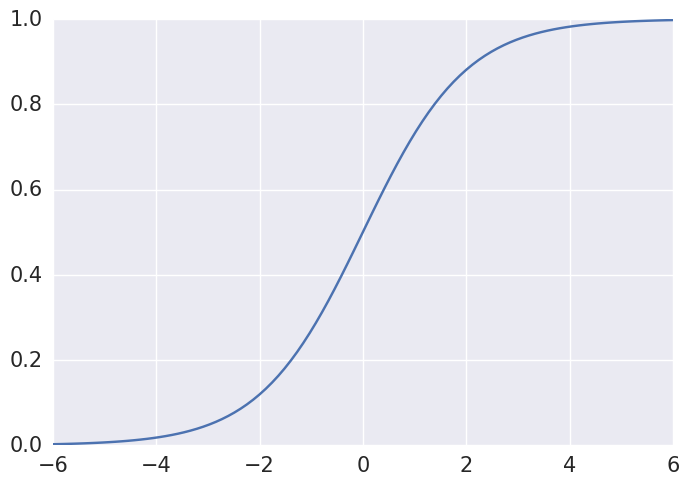

In [46]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

### Data set for classification

In [47]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

### Using gradient descent for classification by logistic regression

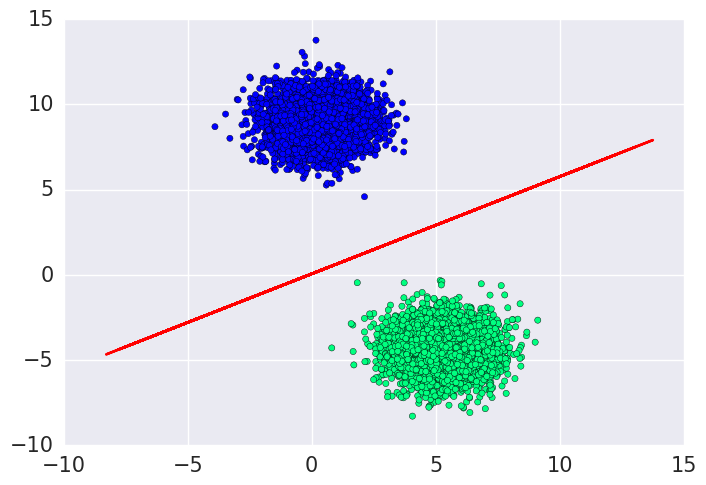

In [48]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [49]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [50]:
def logistic_re(x):
    """Rewrite Logistic function."""
    exp_x = np.exp(x)
    return exp_x/(1 + exp_x)

In [51]:
%timeit logistic_re(x)
%timeit logistic(x)

1 loop, best of 3: 291 ms per loop
1 loop, best of 3: 559 ms per loop


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [52]:
from numba import vectorize, float64

In [53]:
@vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """logistic_numba_cpu"""
    return np.exp(x)/(1 + np.exp(x))

In [54]:
@vectorize([float64(float64)],target='parallel')
def logistic_numba_parallel(x):
    """logistic_numba_parallel"""
    return np.exp(x)/(1 + np.exp(x))

In [55]:
np.testing.assert_array_almost_equal(logistic(x),logistic_numba_cpu(x))
np.testing.assert_array_almost_equal(logistic(x),logistic_numba_parallel(x))

In [56]:
%timeit logistic(x)
%timeit logistic_numba_cpu(x)
%timeit logistic_numba_parallel(x)

1 loop, best of 3: 521 ms per loop
1 loop, best of 3: 216 ms per loop
10 loops, best of 3: 62.6 ms per loop


In [57]:
@jit('double[:](double[:])')
def logistic_numba(x):
    """logistic_numba function."""
    return np.exp(x)/(1 + np.exp(x))

In [58]:
@jit('double[:](double[:, :], double[:], double[:], double, int64)')
def gd_numba(X, y, beta, alpha, niter):
    """Numba version of Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

In [59]:
np.testing.assert_array_almost_equal(gd_numba(X, y, β, α, niter),gd(X, y, β, α, niter))

In [60]:
%timeit gd_numba(X, y, β, α, niter)
%timeit gd(X, y, β, α, niter)

1 loop, best of 3: 368 ms per loop
1 loop, best of 3: 734 ms per loop


**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [61]:
%%cython -a
cimport cython
import numpy as np
from libc.math cimport exp
@cython.cdivision(True)
@cython.wraparound(False)  
@cython.boundscheck(False)
def logistic_cython( double[:] x):
    """logistic cython"""
    cdef double[:] x1 = x
    cdef int i
    cdef double a   
    for i in range(x.shape[0]):
        a = exp(x[i])
        x1[i] = a/(1 + a)
    
    return np.array(x1)

In [62]:
np.testing.assert_array_almost_equal(logistic(x),logistic_cython(x))
%timeit logistic_numba_cpu(x)
%timeit logistic_cython(x)
#The performance is close

1 loop, best of 3: 228 ms per loop
1 loop, best of 3: 247 ms per loop


In [63]:
%%cython -a

cimport cython
import numpy as np
from libc.math cimport exp

@cython.cdivision(True)
@cython.wraparound(False)  
@cython.boundscheck(False)

cdef double[:] logistic_cython(double[:] x):
    """cdef logistic cython"""
    cdef double[:] x1 = x
    cdef int i
    cdef double a
    
    for i in range(x.shape[0]):
        a = exp(x[i])
        x1[i] = a/(1 + a)
    
    return x1


def gd_cython(double[:,:] X, double[:] y, double[:] beta, float alpha, int niter):
    """cython gradient descent"""
    cdef int n,p,i,j,k
    cdef double[:,:] Xt
    cdef double[:] y_pred, gradn         
    cdef double[:] epsilon = y
    
    n = X.shape[0]
    p = X.shape[1]
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_cython( np.dot(X, beta))
        for j in range(len(y)):
            epsilon[j] = y[j] - y_pred[j]
        gradn = np.dot(Xt,epsilon)
        for k in range(len(gradn)):
            beta[k] += gradn[k]*alpha/n
    return np.array(beta)

In [64]:
np.testing.assert_array_almost_equal(gd(X, y, β, α, niter),gd_cython(X, y, β, α, niter))
%timeit gd_numba(X, y, β, α, niter)
%timeit gd_cython(X, y, β, α, niter)

1 loop, best of 3: 448 ms per loop
1 loop, best of 3: 326 ms per loop


**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [65]:
! git clone https://github.com/RLovelett/eigen.git

fatal: destination path 'eigen' already exists and is not an empty directory.


In [66]:
%%file wrap0000.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../eigen']
setup_pybind11(cfg)
%>

namespace py = pybind11;

Eigen::VectorXd logi(Eigen::VectorXd x) {
            return exp(x.array())/(exp(x.array()) + 1);    
}

PYBIND11_PLUGIN(wrap0000) {
    pybind11::module m("wrap0000", "auto-compiled c++ extension");
    m.def("logi", &logi);
    return m.ptr();
}

Overwriting wrap0000.cpp


In [67]:
import cppimport
import numpy as np

code = cppimport.imp("wrap0000")
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)
print(code.logi(x))

ImportError: No module named 'cppimport'

In [ ]:
np.testing.assert_array_almost_equal(logistic(x),code.logi(x))

In [ ]:
x = np.linspace(-6, 6, 100)
plt.plot(x, code.logi(x))
pass

In [ ]:
%%file wrap15.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../eigen']
setup_pybind11(cfg)
%>

namespace py = pybind11;
using namespace pybind11::literals;

Eigen::VectorXd logi(Eigen::VectorXd x) {
            Eigen::MatrixXd logix = exp(x.array());
            return logix.array()/(logix.array() + 1);    
}

Eigen::VectorXd gd(Eigen::MatrixXd X,Eigen::MatrixXd y, Eigen::VectorXd beta, double alpha, int niter) {
            int n = X.rows();
            int p = X.cols();
            Eigen::MatrixXd x_logi;
            Eigen::MatrixXd y_logi;
            Eigen::MatrixXd epsilon;
            Eigen::MatrixXd grad; 
            Eigen::MatrixXd Xt = X.transpose();
            for (int i = 0; i < niter; i++) {
                x_logi = X*beta;
                y_logi = logi(x_logi);
                epsilon = y - y_logi;
                grad = (Xt*epsilon) / n;
                beta = beta + alpha * grad; 
            }
            
            return beta;
}

PYBIND11_PLUGIN(wrap15) {
    pybind11::module m("wrap15", "auto-compiled c++ extension");
    m.def("logi", &logi);
    m.def("gd", &gd);
    return m.ptr();
}

In [ ]:
import cppimport
import numpy as np

code1 = cppimport.imp("wrap15")

n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

niter = 1000
alpha = 0.01
beta = np.zeros(p+1)
print(code1.gd(X,y,beta,alpha,niter))

In [ ]:
np.testing.assert_array_almost_equal(code1.gd(X,y,beta,alpha,niter),gd(X,y,beta,alpha,niter))

In [ ]:
# initial parameters
niter = 1000
alpha = 0.01
beta = np.zeros(p+1)

beta = code1.gd(X, y, beta, alpha, niter)
y_pred = logistic(X @ beta)
labels = y_pred > 0.5
sep = (-beta[0] - beta[1] * X)/beta[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass